In [119]:
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import warnings 
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [120]:
df1 = pd.read_csv('exam_1.csv')
df2 = pd.read_csv('exam_2.csv')

df1['class_x'] = df1['class']
df1 = df1.drop(labels=['class'], axis=1)

df1.head()
df2['class_y'] = df2['class']
df2 = df2.drop('class', axis=1)

df = pd.merge(df1, df2)
df.rename(columns={'Unnamed: 0':"Index"}, inplace=True)
df.set_index('Index', inplace=True)
df.head()


,A,C,E,class_x,B,D,F,class_y
Index,,,,,,,,
0,-0.386248,1.536628,1.232589,1,-1.432057,1.039420,0.280469,1
1,-2.686649,4.640702,0.823433,1,-4.036329,0.526320,-0.419013,1
2,0.474124,1.576616,-1.256234,0,0.179770,0.157974,-0.162869,0
3,-1.343790,-0.514008,1.520392,2,-1.299109,-0.152250,0.045123,2
4,-2.187600,0.289041,1.318321,2,-2.089699,-0.494995,-0.661858,2


In [121]:
print(len(df[df['class_x'] != df['class_y']]))

df0 = df[df['class_x'] == df['class_y']]

print(len(df0[df0['class_x'] != df0['class_y']]))

df0 = df0.drop(columns=['class_y'])
df0 = df0.rename(columns={'class_x':'class'})
df0.head()

16
0


,A,C,E,class,B,D,F
Index,,,,,,,
0,-0.386248,1.536628,1.232589,1,-1.432057,1.039420,0.280469
1,-2.686649,4.640702,0.823433,1,-4.036329,0.526320,-0.419013
2,0.474124,1.576616,-1.256234,0,0.179770,0.157974,-0.162869
3,-1.343790,-0.514008,1.520392,2,-1.299109,-0.152250,0.045123
4,-2.187600,0.289041,1.318321,2,-2.089699,-0.494995,-0.661858


In [122]:
df = df0.reindex(sorted(df0.columns), axis=1)

print("Size of the final dataset is {}".format(df.shape))
df.head()

Size of the final dataset is (1984, 7)


,A,B,C,D,E,F,class
Index,,,,,,,
0,-0.386248,-1.432057,1.536628,1.039420,1.232589,0.280469,1
1,-2.686649,-4.036329,4.640702,0.526320,0.823433,-0.419013,1
2,0.474124,0.179770,1.576616,0.157974,-1.256234,-0.162869,0
3,-1.343790,-1.299109,-0.514008,-0.152250,1.520392,0.045123,2
4,-2.187600,-2.089699,0.289041,-0.494995,1.318321,-0.661858,2


In [123]:
# decision tree
# Neural network
# KNearnest 
from sklearn.linear_model import Perceptron
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

model_lbls = [
              'dt', 
              'lp', 
             'knn',
            ]

# Set the parameters by cross-validation
tuned_param_dt = [{'max_depth': [*range(1,20)]}]
tuned_param_lp = [{'early_stopping': [True]}]
tuned_param_knn =[{'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}]

models = {
    'dt': {'name': 'Decision Tree       ',
           'estimator': DecisionTreeClassifier(), 
           'param': tuned_param_dt,
          },
    'lp': {'name': 'Linear Perceptron   ',
           'estimator': Perceptron(),
           'param': tuned_param_lp,
          },
    'knn':{'name': 'K Nearest Neighbor ',
           'estimator': KNeighborsClassifier(),
           'param': tuned_param_knn
       },
}

scores = ['precision', 'recall']

Let's check the single models, without hyperparameter tuning, first.

In [124]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report

X = df.drop(columns='class')
y = df['class']

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=0.7)
print("Training on {:} samples".format(Xtrain.shape[0]))

accuracy_scores = {} 

for model in model_lbls:
    estimator = models[model]['estimator']
    estimator.fit(Xtrain, ytrain)
    y_pred = estimator.predict(Xtest)
    accuracy_scores[model] = accuracy_score(ytest, y_pred)
    print("Accuracy score for {} is {}".format(models[model]['name'], accuracy_scores[model])) # Basing only on accuracy

print("The best model by accuracy is {}".format(models[max(accuracy_scores, key=accuracy_scores.get)]['name'])) 

Training on 1388 samples
Accuracy score for Decision Tree        is 0.8104026845637584
Accuracy score for Linear Perceptron    is 0.7214765100671141
Accuracy score for K Nearest Neighbor  is 0.8590604026845637
The best model by accuracy is K Nearest Neighbor 


This function allows us to better understand which model/parameter combination is better for the task. 

In [125]:
def print_results(model): # Note: could have put the train part here also...
    print("Best parameters set found on train set:")
    print()
    # if best is linear there is no gamma parameter
    print(model.best_params_)
    print()
    print("Grid scores on train set:")
    print()
    means = model.cv_results_['mean_test_score']
    stds = model.cv_results_['std_test_score']
    params = model.cv_results_['params']
    for mean, std, params_tuple in zip(means, stds, params):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params_tuple))
    print()
    print("Detailed classification report for the best parameter set:")
    print()
    print("The model is trained on the full train set.")
    print("The scores are computed on the full test set.")
    print()
    y_true, y_pred = ytest, model.predict(Xtest)
    print(classification_report(y_true, y_pred))
    print()

Now let's tune the parameters. 

In [126]:
best_scores = {} 

for score in scores:
    for model in model_lbls: # model labels
        
        print('-'*40)
        print("Trying model {}".format(models[model]['name']))
    
        estimator = GridSearchCV(scoring='%s_macro' % score, n_jobs=2, cv=5, # '%s_macro' to format to actual scikit_learn param (accuracy_macro)
            estimator=models[model]['estimator'], param_grid=models[model]['param']) # n_job for multicore cv, param_grids is the 
                                                                                    # list of params to try as values
        estimator.fit(Xtrain, ytrain) # this step must be done, or else no best score
        
        print_results(estimator)
        best_scores[model] = estimator.best_score_


    print("Summary of results for {}".format(score)) # copy pasted from official solution since i hate printing stuff :|
    print("Estimator")
    for m in best_scores.keys():
        print("{}\t - score: {:4.2}%".format(models[m]['name'], best_scores[m]))

----------------------------------------
Trying model Decision Tree       
Best parameters set found on train set:

{'max_depth': 5}

Grid scores on train set:

0.428 (+/-0.019) for {'max_depth': 1}
0.821 (+/-0.032) for {'max_depth': 2}
0.825 (+/-0.033) for {'max_depth': 3}
0.826 (+/-0.052) for {'max_depth': 4}
0.834 (+/-0.050) for {'max_depth': 5}
0.825 (+/-0.052) for {'max_depth': 6}
0.834 (+/-0.053) for {'max_depth': 7}
0.830 (+/-0.031) for {'max_depth': 8}
0.833 (+/-0.039) for {'max_depth': 9}
0.823 (+/-0.019) for {'max_depth': 10}
0.830 (+/-0.034) for {'max_depth': 11}
0.833 (+/-0.030) for {'max_depth': 12}
0.826 (+/-0.036) for {'max_depth': 13}
0.834 (+/-0.015) for {'max_depth': 14}
0.830 (+/-0.022) for {'max_depth': 15}
0.828 (+/-0.046) for {'max_depth': 16}
0.830 (+/-0.028) for {'max_depth': 17}
0.826 (+/-0.032) for {'max_depth': 18}
0.829 (+/-0.027) for {'max_depth': 19}

Detailed classification report for the best parameter set:

The model is trained on the full train set.
Th

We are now instantiating the models using the best parameters found so far.

In [127]:
dt = DecisionTreeClassifier(max_depth=7)
lp = Perceptron(early_stopping=True)
knn = KNeighborsClassifier(n_neighbors=7)

For each classification method, compute the _accuracy_ and the _confusion matrix_ on the test set
 

In [131]:
from sklearn.metrics import confusion_matrix

accuracy_scores = [] 

dt.fit(Xtrain, ytrain)
y_pred = dt.predict(Xtest)
accuracy_scores.append(accuracy_score(ytest, y_pred))

conf_dt = confusion_matrix(ytest, y_pred)
print("Confusion matrix of DT: ")
print(conf_dt)

lp.fit(Xtrain, ytrain)
y_pred = lp.predict(Xtest)
accuracy_scores.append(accuracy_score(ytest, y_pred))

conf_lp = confusion_matrix(ytest, y_pred) 
print("Confusion matrix of LP: ")
print(conf_lp)

knn.fit(Xtrain, ytrain)
y_pred = knn.predict(Xtest)
accuracy_scores.append(accuracy_score(ytest, y_pred))

conf_knn = confusion_matrix(ytest, y_pred)
print("Confusion matrix of KNN: ")
print(conf_knn)


Confusion matrix of DT: 
[[164  25  15]
 [ 22 139  12]
 [ 12  18 189]]
Confusion matrix of LP: 
[[152  34  18]
 [ 11 131  31]
 [ 42   5 172]]
Confusion matrix of KNN: 
[[159  29  16]
 [ 14 151   8]
 [  6  12 201]]


<BarContainer object of 3 artists>

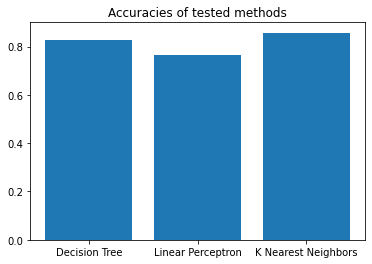

In [132]:

classfier_names = ['Decision Tree', 'Linear Perceptron', 'K Nearest Neighbors']
plt.title('Accuracies of tested methods')
plt.bar(classfier_names, accuracy_scores)